## IMPORT LIBRARIES

In [55]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
import os
import time

import numpy as np

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

from tqdm import tqdm, trange
from torchvision import datasets, models, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.4)

In [57]:
torch.cuda.is_available()

False

In [66]:
use_gpu = torch.cuda.is_available()

## IMPORT DATA

In [155]:
# Преобразование обучающих данных для расширения обучающей выборки и её нормализация
# Для валидационной (тестовой) выборки только нормализация
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(244),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        # Векторы среднего значения и стандартного отклонения, можно брать из предобученного датасета
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize([244,244]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [156]:
data_dir = '/content/drive/MyDrive/dasha_tima_data'
image_datasets = datasets.ImageFolder(data_dir, data_transforms['val'])
len(image_datasets)

93

In [157]:
train, val, test = torch.utils.data.random_split(image_datasets, [.7, .2, 0.1])

In [158]:
image_dataset = {'train': train, 'val': val, 'test': test}

In [159]:
dataloaders = {x: torch.utils.data.DataLoader(image_dataset[x], batch_size=8,
                                              shuffle=True, num_workers=2)
               for x in ['train', 'val', 'test']}

In [160]:
dataset_sizes = {x: len(image_dataset[x]) for x in ['train', 'val', 'test']}
class_names = image_dataset['train'].dataset.classes

In [161]:
print(dataset_sizes)

{'train': 66, 'val': 18, 'test': 9}


### SHOW IMAGES

In [162]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(15, 12))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

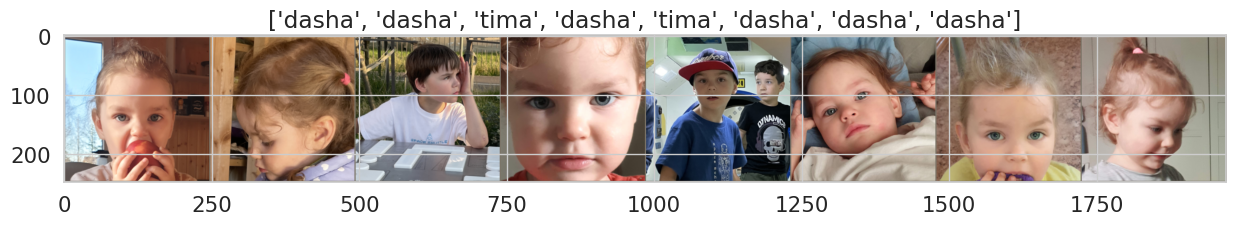

In [163]:
# Получим 1 батч (картнки-метки) из обучающей выборки
inputs, classes = next(iter(dataloaders['test']))

# Расположим картинки рядом
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### MODEL FUNCTION

In [59]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    #Ваш код здесь
    losses = {'train': [], "val": []}
    accuracy = {'train': [], "val": []}

    pbar = trange(num_epochs, desc="Epoch:")

    for epoch in pbar:

        # каждя эпоха имеет обучающую и тестовую стадии
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # установаить модель в режим обучения
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # итерируемся по батчам
            for data in tqdm(dataloaders[phase], leave=False, desc=f"{phase} iter:"):
                # получаем картинки и метки
                inputs, labels = data

                # оборачиваем в переменные
                if use_gpu:
                    inputs = inputs.cuda()
                    labels = labels.cuda()
                else:
                    inputs, labels = inputs, labels

                # инициализируем градиенты параметров
                if phase=="train":
                    optimizer.zero_grad()

                # forward pass
                if phase == "eval":
                    with torch.no_grad():
                        outputs = model(inputs)
                else:
                    outputs = model(inputs)
                preds = torch.argmax(outputs, -1)
                loss = criterion(outputs, labels)

                # backward pass + оптимизируем только если это стадия обучения
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # статистика
                running_loss += loss.item()
                running_corrects += int(torch.sum(preds == labels.data))

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            
            losses[phase].append(epoch_loss)
            accuracy[phase].append(epoch_acc)

            pbar.set_description('{} Loss: {:.4f} Acc: {:.4f}'.format(
                                    phase, epoch_loss, epoch_acc
                                ))

            # если достиглось лучшее качество, то запомним веса модели
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # загрузим лучшие веса модели
    model.load_state_dict(best_model_wts)
    return model, losses, accuracy

In [60]:
def evaluate(model):
    model.eval()

    runninig_correct = 0
    for data in dataloaders['val']:
        # получаем картинки и метки
        inputs, labels = data

        # переносим на gpu, если возможно
        if use_gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()

        # forard pass
        output = model(inputs)
        _, predicted = torch.max(output, 1)

        runninig_correct += int(torch.sum(predicted == labels))

    return runninig_correct / dataset_sizes['val']

In [61]:
def visualize_model(model, num_images=6):
    plt.figure(figsize=(10, 10))

    for i, data in enumerate(dataloaders['test']):
        inputs, labels = data
        if use_gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            ax = plt.subplot(3, 3, j + 1)
            ax.axis('off')
            inp = inputs.cpu().data[j]
            inp = inp.numpy().transpose((1, 2, 0))
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            inp = std * inp + mean
            img = np.clip(inp, 0, 1)
            plt.imshow(img)
            plt.title('predicted: {}'.format(class_names[preds[j]]))

## VGG 16

In [144]:
model_extractor = models.vgg16(weights='VGG16_Weights.IMAGENET1K_V1')

In [145]:
# замораживаем параметры (веса)
for param in model_extractor.parameters():
    param.requires_grad = False

# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 25088
# Заменяем Fully-Connected слой на наш линейный классификатор
model_extractor.classifier = nn.Linear(num_features, 2)

# Использовать ли GPU
if use_gpu:
    model_extractor = model_extractor.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# Обучаем только классификатор
optimizer = optim.SGD(model_extractor.classifier.parameters(), lr=0.001, momentum=0.9)

# gamma умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [146]:
model_extractor, losses, accuracy = train_model(model_extractor, loss_fn, optimizer, exp_lr_scheduler, num_epochs=10)

val Loss: 0.0952 Acc: 0.9444: 100%|██████████| 5/5 [00:19<00:00,  3.86s/it]

Training complete in 0m 19s
Best val Acc: 0.944444


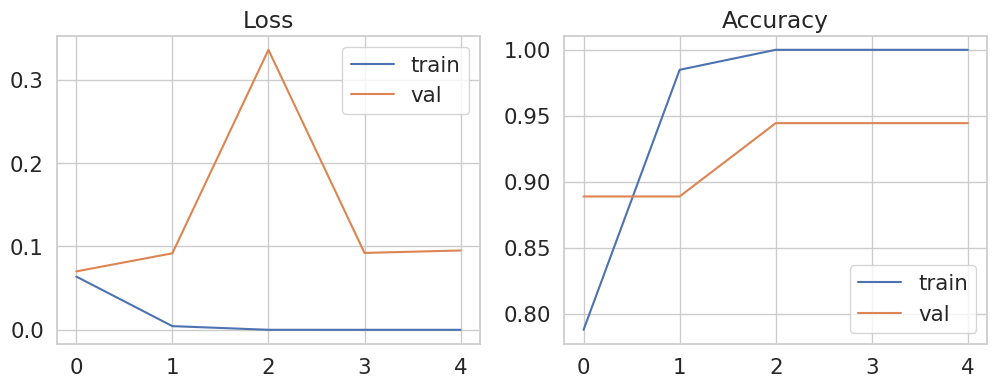

In [147]:
# Построим графики лосса и точности при обучении и валидации
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

ax1.plot(losses['train'], label="train")
ax1.plot(losses['val'], label="val")
ax1.set_title('Loss {:.3f}' .format(losses['val'][-1]))
ax1.legend(loc="upper right")
ax2.plot(accuracy['train'], label="train")
ax2.plot(accuracy['val'], label="val")
ax2.set_title('Accuracy {:.3f}' .format(accuracy['val'][-1]))
ax2.legend(loc="lower right")
plt.show()

In [148]:
print("Accuracy: {0:.4f}".format(evaluate(model_extractor)))

Accuracy: 0.9444


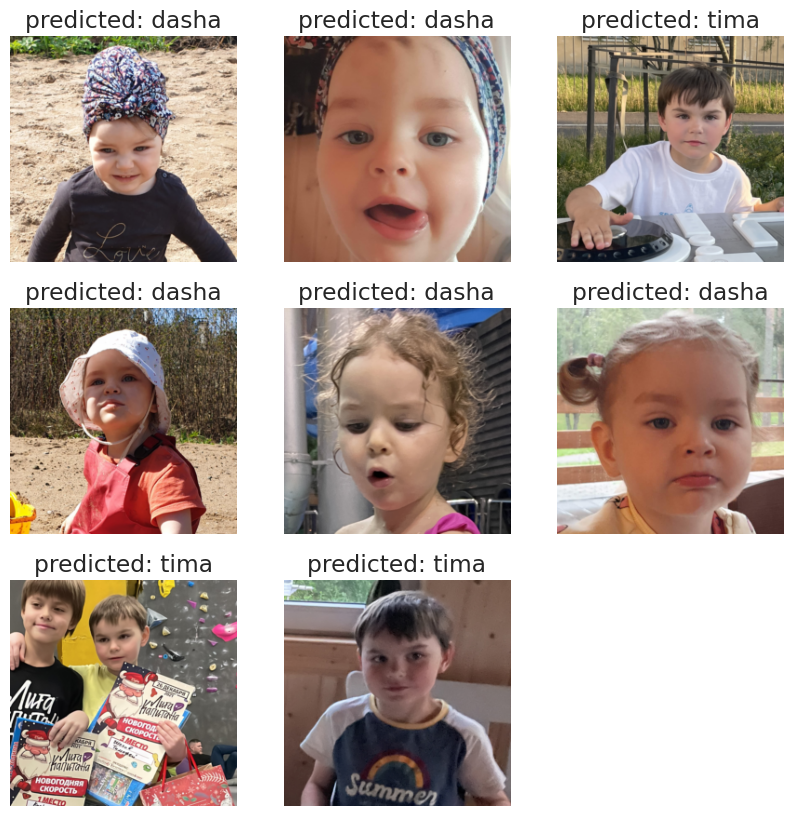

In [149]:
visualize_model(model_extractor, dataset_sizes['test'])

## INCEPTION V3

In [67]:
# Нужно поменять размер картинок на 299, иначе будет ошибка, так как размерность станет отрицательной.
# Это вызвано тем, что нейросеть изначально обучалась на картинках размера 299.

# Результирующий размер картинок определяется трансформациями
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop([299,299]),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        # Векторы среднего значения и стандартного отклонения, можно брать из предобученного датасета
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize([299,299]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [68]:
image_datasets = datasets.ImageFolder(data_dir, data_transforms['val'])
len(image_datasets)

93

In [69]:
train, val, test = torch.utils.data.random_split(image_datasets, [.7, .2, 0.1])

image_dataset = {'train': train, 'val': val, 'test': test}


dataloaders = {x: torch.utils.data.DataLoader(image_dataset[x], batch_size=8,
                                              shuffle=True, num_workers=2)
               for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_dataset[x]) for x in ['train', 'val', 'test']}

class_names = image_dataset['train'].dataset.classes
print(dataset_sizes)

{'train': 66, 'val': 18, 'test': 9}


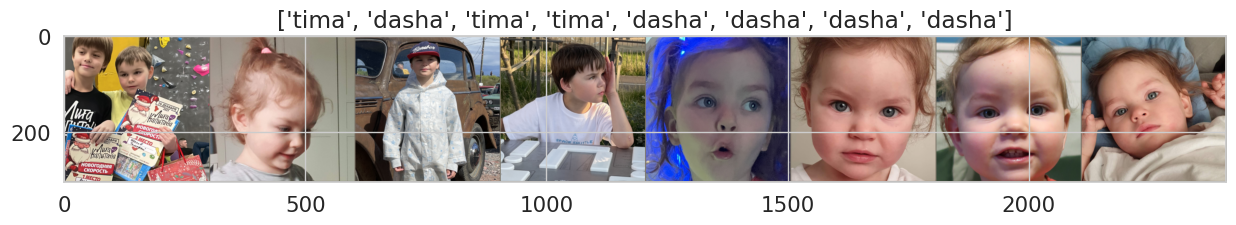

In [70]:
# Получим 1 батч (картнки-метки) из обучающей выборки
inputs, classes = next(iter(dataloaders['test']))

# Расположим картинки рядом
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [140]:
model_inception_v3 = models.inception_v3(weights='Inception_V3_Weights.DEFAULT')

In [ ]:
# так можно посмотреть архитектуру модели
summary(model_inception_v3, (3, 299, 299))
print(model_inception_v3)

In [130]:
# замораживаем параметры (веса)

'''
for param in model_inception_v3.parameters():
    param.requires_grad = False
    '''

# конкретно на этом датасете дает результат хуже

In [141]:
# inception_v3 содержит несколько выходных слоев, поэтому нужно заменить все
# в результате получим следующие изменения:
'''
БЫЛО:
...
  (AuxLogits): InceptionAux(
...    
        (fc): Linear(in_features=768, out_features=1000, bias=True)
  )
...

(fc): Linear(in_features=2048, out_features=1000, bias=True)
...

СТАЛО:
...
  (AuxLogits): InceptionAux(
...    
        (fc): Linear(in_features=768, out_features=2, bias=True)
  )
...

(fc): Linear(in_features=2048, out_features=2, bias=True)
...

'''


model_inception_v3.AuxLogits.fc = nn.Linear(768, 2)
model_inception_v3.fc = nn.Linear(2048, 2)

In [142]:
# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 25088

# Блок не нужен т.к. в первоначальной модели нет Classifier, просто дублируем последний блок
# model_inception_v3.classifier = nn.Linear(num_features, 2)

# Использовать ли GPU
if use_gpu:
    model_inception_v3 = model_inception_v3.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# Обучаем все слои
optimizer = optim.Adam(model_inception_v3.parameters(), lr=1e-4)

# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [143]:
# проверяем, что у  линейных слоев requires_grad=True
for param in model_inception_v3.fc.parameters():
  print(param)

Parameter containing:
tensor([[-0.0025, -0.0095,  0.0166,  ..., -0.0158, -0.0139,  0.0044],
        [ 0.0101, -0.0059, -0.0157,  ..., -0.0184, -0.0117,  0.0008]],
       requires_grad=True)
Parameter containing:
tensor([ 0.0029, -0.0063], requires_grad=True)


In [144]:
%%time
model_inception_v3.aux_logits = False
model_extractor, losses, accuracy = train_model(model_inception_v3, loss_fn, optimizer, exp_lr_scheduler, num_epochs=3)

Epoch::   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "

val Loss: 0.0249 Acc: 1.0000: 100%|██████████| 3/3 [03:41<00:00, 73.93s/it]


Training complete in 3m 42s
Best val Acc: 1.000000
CPU times: user 3min 18s, sys: 9.85 s, total: 3min 28s
Wall time: 3min 41s


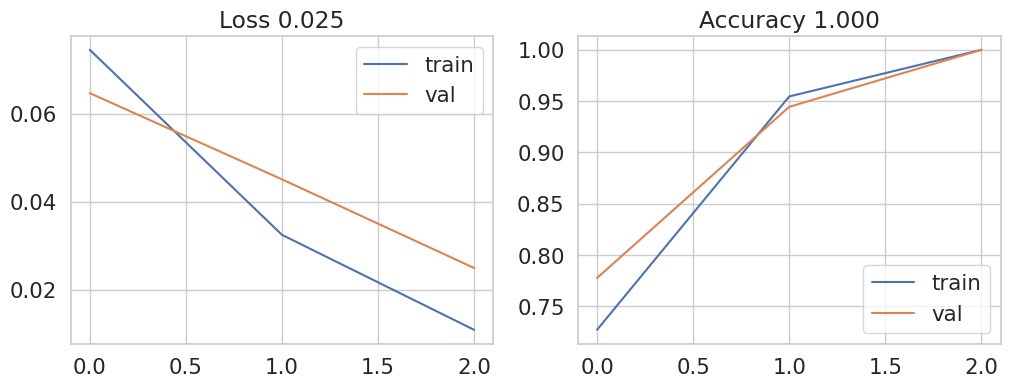

In [145]:
# Построим графики лосса и точности при обучении и валидации
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

ax1.plot(losses['train'], label="train")
ax1.plot(losses['val'], label="val")
ax1.set_title('Loss {:.3f}' .format(losses['val'][-1]))
ax1.legend(loc="upper right")
ax2.plot(accuracy['train'], label="train")
ax2.plot(accuracy['val'], label="val")
ax2.set_title('Accuracy {:.3f}' .format(accuracy['val'][-1]))
ax2.legend(loc="lower right")
plt.show()

In [146]:
print("Accuracy: {0:.4f}".format(evaluate(model_extractor)))

Accuracy: 1.0000


In [147]:
visualize_model(model_extractor, dataset_sizes['test'])

## Efficient Net

In [150]:
!pip install efficientnet_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=4aed7501da2bde91a3373fa97961be72afc71d97899e0412568ff07b33473c4b
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [151]:
from efficientnet_pytorch import EfficientNet
efficientnet_model = EfficientNet.from_pretrained('efficientnet-b2')

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b2-8bb594d6.pth
100%|██████████| 35.1M/35.1M [00:00<00:00, 146MB/s]


Loaded pretrained weights for efficientnet-b2


In [164]:
# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 1408
# Заменяем Fully-Connected слой на наш линейный классификатор
efficientnet_model._fc = nn.Linear(num_features, 2)

In [165]:
# Использовать ли GPU
if use_gpu:
    efficientnet_model = efficientnet_model.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

optimizer = optim.SGD(efficientnet_model.parameters(), lr=0.001, momentum=0.9)

# gamma умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [166]:
efficientnet_model, losses, accuracy = train_model(efficientnet_model, loss_fn, optimizer, exp_lr_scheduler, num_epochs=5)

val Loss: 0.0881 Acc: 0.7778: 100%|██████████| 5/5 [03:59<00:00, 47.92s/it]

Training complete in 3m 60s
Best val Acc: 0.777778


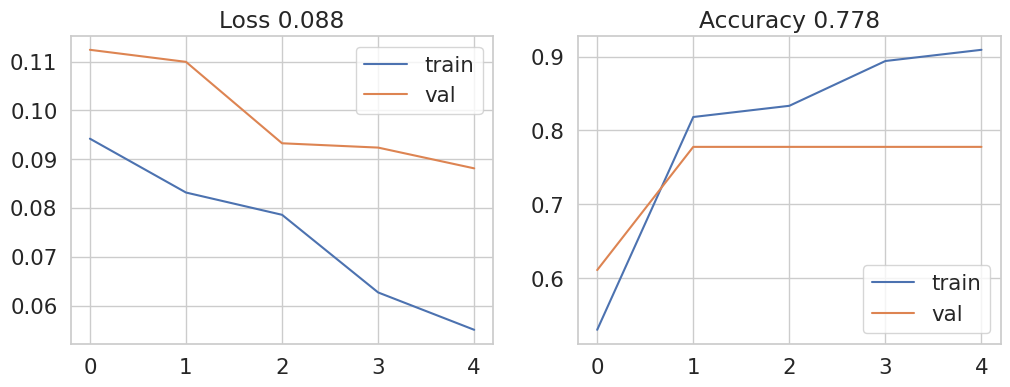

In [167]:
# Построим графики лосса и точности при обучении и валидации
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

ax1.plot(losses['train'], label="train")
ax1.plot(losses['val'], label="val")
ax1.set_title('Loss {:.3f}' .format(losses['val'][-1]))
ax1.legend(loc="upper right")
ax2.plot(accuracy['train'], label="train")
ax2.plot(accuracy['val'], label="val")
ax2.set_title('Accuracy {:.3f}' .format(accuracy['val'][-1]))
ax2.legend(loc="lower right")
plt.show()

In [168]:
print("Accuracy: {0:.4f}".format(evaluate(efficientnet_model)))

Accuracy: 0.7778


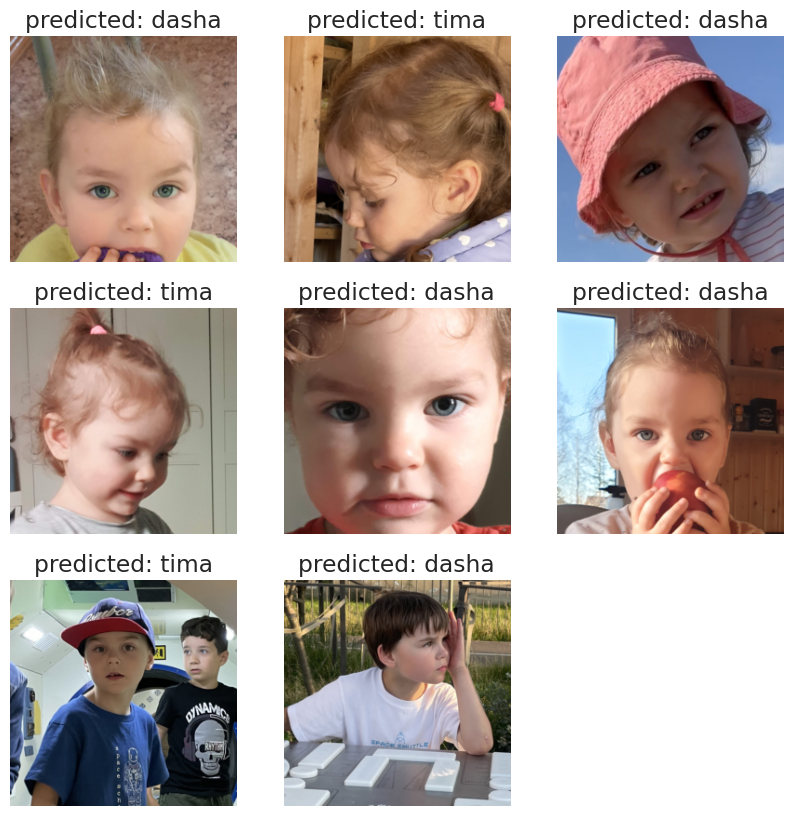

In [169]:
visualize_model(efficientnet_model, dataset_sizes['test'])

In [170]:
efficientnet_model, losses, accuracy = train_model(efficientnet_model, loss_fn, optimizer, exp_lr_scheduler, num_epochs=15)

val Loss: 0.0770 Acc: 0.9444: 100%|██████████| 15/15 [11:20<00:00, 45.35s/it]

Training complete in 11m 20s
Best val Acc: 0.944444


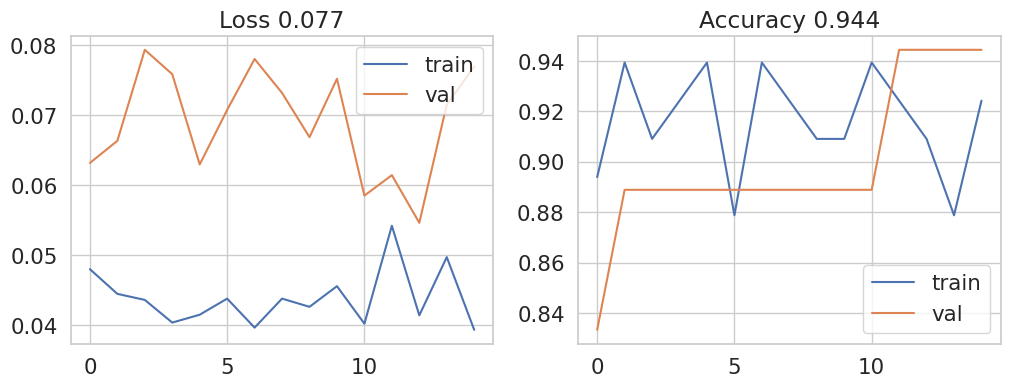

In [171]:
# Построим графики лосса и точности при обучении и валидации
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

ax1.plot(losses['train'], label="train")
ax1.plot(losses['val'], label="val")
ax1.set_title('Loss {:.3f}' .format(losses['val'][-1]))
ax1.legend(loc="upper right")
ax2.plot(accuracy['train'], label="train")
ax2.plot(accuracy['val'], label="val")
ax2.set_title('Accuracy {:.3f}' .format(accuracy['val'][-1]))
ax2.legend(loc="lower right")
plt.show()

In [172]:
print("Accuracy: {0:.4f}".format(evaluate(efficientnet_model)))

Accuracy: 0.9444


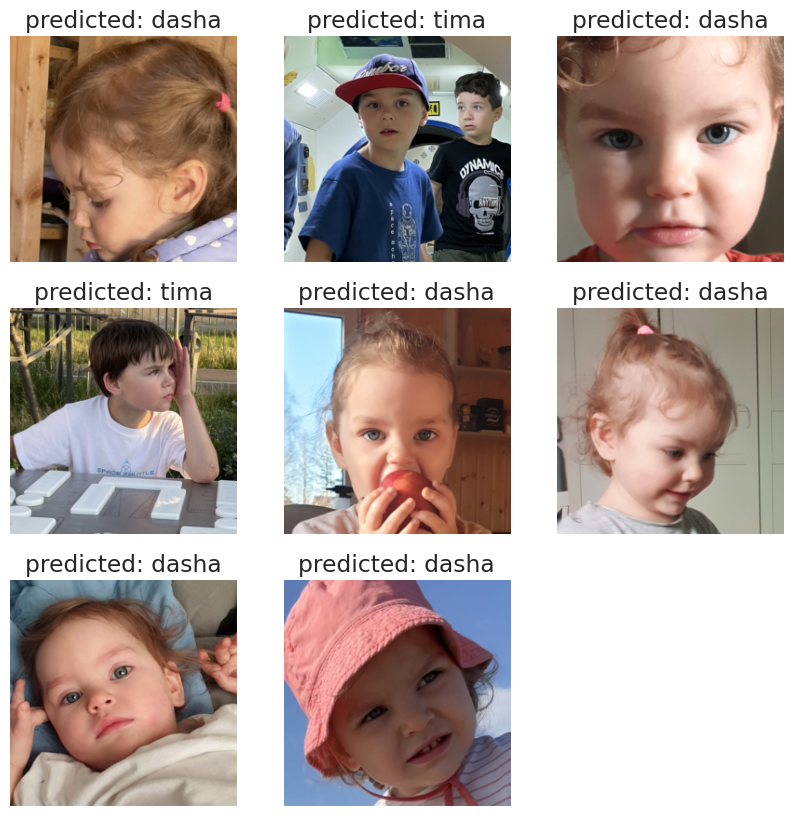

In [173]:
visualize_model(efficientnet_model, dataset_sizes['test'])